<a href="https://colab.research.google.com/github/nebuchadnezzarr/DL-ML/blob/master/VERA_NN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install python-resize-image

     |████████████████████████████████| 2.1MB 8.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import keras                                                 #библиотека для построения модели
from keras.models import Sequential                          #тип модели
from keras.layers import Conv2D, Dense, Flatten, Activation  #слои для нейронной сети, которые будем использовать
from keras.layers import MaxPooling2D, Dropout, BatchNormalization
import numpy as np  
import os                                                    #для манипуляций с файлами (чтение и т.п.)
import cv2                                                   #для преобразования картинок в матрицы
import matplotlib.pyplot as plt                              #примерно похожа на предыдущее, но иногда работает лучше 
from keras.preprocessing.image import ImageDataGenerator     #помогает закидывать данные в сеть
from PIL import Image
from resizeimage import resizeimage
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools
import random
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_yaml
import gc
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q /content/gdrive/'My Drive'/hack_project.zip 

In [0]:
%cd hack_project

/content/hack_project


In [0]:
!ls
!ls test/
!ls train/

test  train
asterisk  blade  gun  knife
asterisk  blade  gun  knife


In [0]:
train_dir='/content/hack_project/train/'
train_asterisk=[train_dir+'asterisk/{}'.format(i) for i in os.listdir(train_dir+'asterisk')]
train_blade=[train_dir+'blade/{}'.format(i) for i in os.listdir(train_dir+'blade')]
train_gun=[train_dir+'gun/{}'.format(i) for i in os.listdir(train_dir+'gun')]
train_knife=[train_dir+'knife/{}'.format(i) for i in os.listdir(train_dir+'knife')]


In [0]:
train_imgs=train_asterisk+train_blade+train_gun+train_knife

In [0]:
random.shuffle(train_imgs)

In [0]:
del train_asterisk
del train_blade
del train_gun
del train_knife
gc.collect()


32802

In [0]:
import matplotlib.image as mpimg
import seaborn as sns

nrows=150
ncolumns=150
channels=1


In [0]:
def read_and_process_image(list_of_images):
    X=[]
    y=[]
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC))
        if 'asterisk' in image:
            y.append(0)
        elif 'blade' in image:
            y.append(1)
        elif 'gun' in image:
            y.append(2)
        elif 'knife' in image:
            y.append(3)
    
    return X, y


In [0]:
X, y = read_and_process_image(train_imgs)

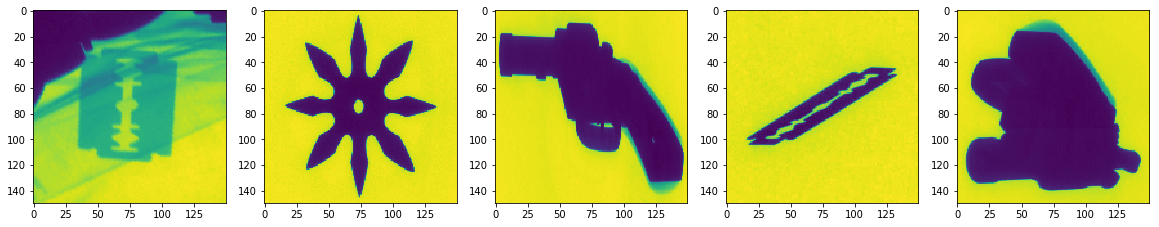

In [0]:
plt.figure(figsize=(20, 10))
columns=5
for i in range (columns):
    plt.subplot(5/columns+1, columns, i+1)
    plt.imshow(X[i])


In [0]:
del train_imgs
gc.collect()


10924

In [0]:
X=np.array(X)
y=np.array(y)
X = np.expand_dims(X, axis=3)


In [0]:
unique=np.array(np.unique(y, return_counts=True)).T
print(unique)


[[  0 262]
 [  1 159]
 [  2 180]
 [  3 289]]


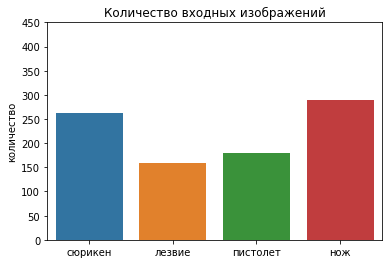

Форма всех изображений: (890, 150, 150, 1)
Форма названий: (890,)


In [0]:
ax = sns.countplot(y)
ax.set_xticklabels(['сюрикен', 'лезвие', 'пистолет', 'нож'])
ax.set_ylabel('количество')
ax.set_yticks([t*50 for t in range(10)])
plt.title('Количество входных изображений')
plt.show()

print('Форма всех изображений:', X.shape)
print('Форма названий:', y.shape)


In [0]:
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.20, random_state=2)

y_test=y_val
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
num_classes=y_train.shape[1]

#Преобразование изображений к необходимой форме
X_train=X_train.reshape(X_train.shape[0], 150, 150, 1).astype('float32')
X_val=X_val.reshape(X_val.shape[0], 150, 150, 1).astype('float32')

print('Форма изображений для тренировки:', X_train.shape)
print('Форма изображений для валидации:', X_val.shape)
print('Форма названий для тренировки:', y_train.shape)
print('Форма названий для валидации:', y_val.shape)

Форма изображений для тренировки: (712, 150, 150, 1)
Форма изображений для валидации: (178, 150, 150, 1)
Форма названий для тренировки: (712, 4)
Форма названий для валидации: (178, 4)


In [0]:
#Сборка мусора
del X
del y
gc.collect()



2120

In [0]:
#Длина данных для тренировки и валидации
ntrain=len(X_train)
nval=len(X_val)

batch_size=32


In [0]:
#Модель сверточной нейронной сети
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
    
    return model


In [0]:
#Масштабирование изображений в промежутке от 0 до 1 и аугментация
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)


#Масштабирование изображений в промежутке от 0 до 1
val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow(X_train, y_train, batch_size=batch_size)

val_generator=val_datagen.flow(X_val, y_val, batch_size=batch_size)

test_generator=train_datagen.flow(X_val, y_val, batch_size=batch_size)



In [0]:
#Инициализация нейронной сети
model=cnn_model()


W0823 16:31:52.271782 139723143690112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 16:31:52.321409 139723143690112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 16:31:52.329370 139723143690112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 16:31:52.366026 139723143690112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0823 16:31:52.432871 139723143690112 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

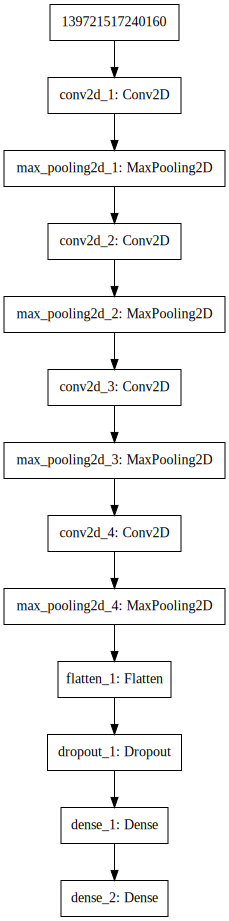

In [0]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
#Тренировка нейронной сети
history=model.fit_generator(train_generator,
                            steps_per_epoch=ntrain//batch_size,
                            epochs=60,
                            validation_data=val_generator,
                            validation_steps=nval//batch_size)

#Команда для начала тренировки сети. 
#Количество шагов за эпоху равно суммарному количеству картинок / каоличество картинок в одном баче (это нужно, чтобы за одну эпоху обучение прошло по всем картинкам), то же касается шагов валидации

W0823 16:32:17.851485 139723143690112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
22/22 [==============================] - 9s 411ms/step - loss: 1.2523 - acc: 0.3935 - val_loss: 1.0466 - val_acc: 0.4750
Epoch 2/60
22/22 [==============================] - 2s 93ms/step - loss: 0.9077 - acc: 0.6280 - val_loss: 0.5896 - val_acc: 0.8562
Epoch 3/60
22/22 [==============================] - 2s 84ms/step - loss: 0.6977 - acc: 0.7209 - val_loss: 0.3889 - val_acc: 0.9315
Epoch 4/60
22/22 [==============================] - 2s 87ms/step - loss: 0.5610 - acc: 0.7966 - val_loss: 0.7573 - val_acc: 0.6849
Epoch 5/60
22/22 [==============================] - 2s 87ms/step - loss: 0.5247 - acc: 0.7998 - val_loss: 0.3665 - val_acc: 0.8562
Epoch 6/60
22/22 [==============================] - 2s 88ms/step - loss: 0.4255 - acc: 0.8492 - val_loss: 0.3570 - val_acc: 0.8836
Epoch 7/60
22/22 [==============================] - 2s 87ms/step - loss: 0.4882 - acc: 0.8124 - val_loss: 0.2651 - val_acc: 0.9000
Epoch 8/60
22/22 [==============================] - 2s 89ms/step - loss: 0.4310 - 

In [0]:
#Сохранение обученных весов
model.save_weights('model_weights5.h5')
#Сохранение модели сети
model.save('model_keras.h5')


In [0]:
#Загрузка обученных весов
model.load_weights('model_weights5.h5')


In [0]:
#Получение точности валидации
scores = model.evaluate_generator(val_generator, nval//batch_size)
print('Точность на тестовых данных: ', scores[1])
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(acc)+1)


Точность на тестовых данных:  0.9794520515285127


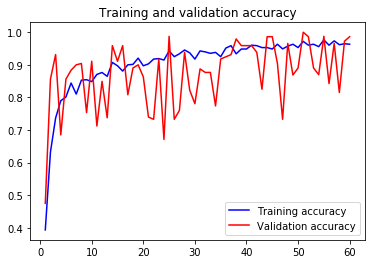

In [0]:
#График точности обучения и валидации
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


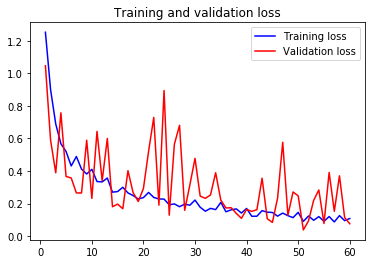

In [0]:
#График потери при обучении и валидации
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



[[1.05521614e-02 5.29728859e-05 9.23244370e-05 9.89302576e-01]
 [1.27797490e-02 2.97303395e-05 4.65192075e-04 9.86725330e-01]
 [4.61290367e-02 8.33157810e-06 1.16463350e-04 9.53746200e-01]
 [3.45191931e-10 1.66243473e-12 1.00000000e+00 4.35587399e-11]
 [9.99558747e-01 2.85937507e-15 3.50228016e-04 9.10105009e-05]
 [1.00336273e-07 1.86929228e-09 9.99999881e-01 5.31494315e-08]
 [2.40660811e-04 9.53465998e-01 2.66314065e-03 4.36302274e-02]
 [6.46456517e-03 7.87610246e-04 1.18262316e-04 9.92629647e-01]
 [4.46164906e-01 7.72955048e-07 6.44193206e-04 5.53190112e-01]
 [3.12198906e-10 6.96890656e-10 1.00000000e+00 9.16160814e-10]
 [3.55457552e-02 1.11752262e-04 5.99059917e-04 9.63743448e-01]
 [1.34010392e-03 2.07956415e-04 4.63416036e-05 9.98405635e-01]
 [2.24691052e-02 4.85449273e-04 2.77247425e-04 9.76768136e-01]
 [8.95245746e-03 8.01620248e-04 2.56948464e-04 9.89988923e-01]
 [7.08043970e-08 6.00148720e-15 9.99999881e-01 7.42546042e-12]
 [2.59612873e-02 1.68461349e-06 2.58134769e-05 9.740113

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


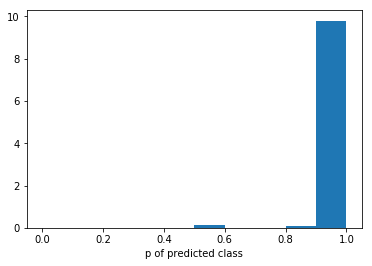

0.98073274
0.5531901


In [0]:
#Получение минимального и максималого порока точности распознавания
cnn_probab = model.predict_generator(val_generator, nval//batch_size)
print(cnn_probab)
p_max = np.amax(cnn_probab, axis=1)

plt.hist(p_max, normed=True, bins=list(np.linspace(0,1,11)));
plt.xlabel('p of predicted class');
plt.show()

print(np.mean(p_max))
print(np.amin(p_max))


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


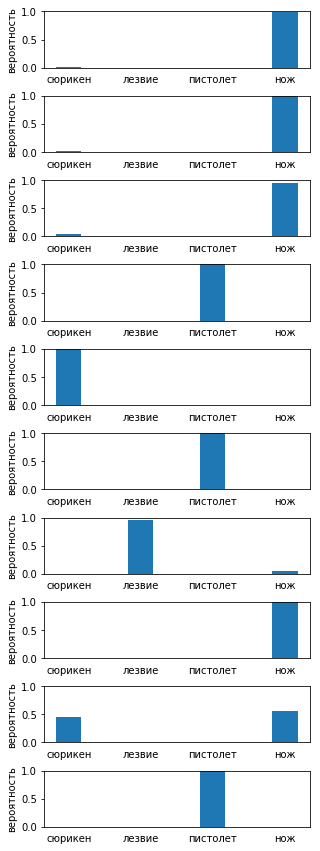

In [0]:
#Классы объектов
label_dict={0: 'сюрикен', 1: 'лезвие', 2:'пистолет', 3:'нож'}

fig, ax = plt.subplots(figsize=(6,15))

for i in range(10):
    #Вывод графика точности распознавания
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(4), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(4), ['сюрикен', 'лезвие', 'пистолет', 'нож'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('вероятность')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)


([], <a list of 0 Text yticklabel objects>)

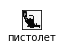

In [0]:
    #Вывод распознанных изображений
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_val[i].reshape((150,150)),cmap='gray', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]);
    plt.xticks([])
    plt.yticks([])
